In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import dalmatian
from importlib import reload
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib import patches
from natsort import natsorted
import plotly.graph_objects as go
from intervaltree import IntervalTree, Interval

In [9]:
def plot_rainfall(maf, sample_name, csize, ax=None, marker_colors='highlight', alpha=1):
    """Make the rainfall plot for this given maf with given specifications.

    :param maf: mutation maf
    :param sample_name: sample_name str
    :param csize: dict with chrom sizes
    :param ax: matplotlib Figure axes (if not provided, new Figure is created and axis returned)
    :param marker_colors: how to color the mutations, one of ['single', 'highlight', 'by_context', 'snp_v_indel']
    :param alpha: alpha value for markers
    :return: Figure axes
    """
    if not ax:
        fig, ax = plt.subplots()
        ax.set_title(f'{sample_name} Rainfall Plot')

    maf, chr_order, chrom_start, _ = prepare_df(maf, csize, suffix='_position')

    maf['distance_prev'] = calc_intermutational_distance(maf)

    maf['mutation'] = maf.apply(lambda x: x['Reference_Allele'] + '_' + x['Tumor_Seq_Allele2'], axis=1)
    maf.replace({'G_C': 'C_G',
                 'G_T': 'C_A',
                 'G_A': 'C_T',
                 'A_C': 'T_G',
                 'A_T': 'T_A',
                 'A_G': 'T_C'}, inplace=True)
    context_list = ['C_T', 'C_G', 'C_A', 'T_C', 'T_G', 'T_A']

    if marker_colors == 'highlight':
        color_list = ['#000000', '#FF2525']
        _, _, clusters_df = get_kataegis_clusters(maf, csize, sample_name)
        cluster_tree = IntervalTree(
            Interval(int(x['start']), int(x['end']), x['chr']) for index, x in clusters_df.iterrows())
        maf['color'] = maf.apply(
            lambda x: color_list[1] if kataegis_mut(cluster_tree, x['Start_position'], x['Chromosome']) else color_list[0], axis=1)
    else:
        if marker_colors == 'by_context':
            color_list = ['#FEFF00', '#FE0200', '#08B4B4', '#18CF18', '#0B2DCD', '#8349B4', '#000000']
        elif marker_colors == 'snp_v_indel':
            color_list = ['#0752BA', '#0752BA', '#0752BA', '#0752BA', '#0752BA', '#0752BA', '#FA0012']
        elif marker_colors == 'single':
            color_list = ['#000000'] * 7
        else:
            color_list = ['#000000'] * 7
        color_dict = {context: col for context, col in zip(context_list + ['indel'], color_list)}
        maf.loc[~maf['mutation'].isin(context_list), 'mutation'] = 'indel'
        maf['color'] = maf['mutation'].apply(lambda x: color_dict[x])

    add_background(ax, chr_order, csize, height=10**7)

    scatter = ax.scatter(x=maf['genome_start'], y=maf['distance_prev'], s=6, c=maf['color'], label=maf['mutation'], alpha=alpha, edgecolors='none')
    ax.set_yscale('log')

    ax.set_xticks(np.asarray(list(chrom_start.values())[:-1]) + np.asarray(list(csize.values())) / 2)
    ax.set_xticklabels(chr_order, fontsize=12)
    ax.set_xlim(chrom_start[chr_order[0]], chrom_start['Z'])
    ax.set_ylim(0.7, 10**7)
    ax.set_ylabel("Mutation Distance")

    plt.yticks(fontsize=12)

    return ax

In [21]:
def plot_acr(seg_df, sample_name, csize, ax=None, segment_colors='difference'):
    """Wrapper for the plot_acr_static method, adding additional layout changes."""
    if not ax:
        fig, ax = plt.subplots()
        ax.set_title(f'{sample_name} ACR Plot')

    plot_acr_static(seg_df, ax, csize, segment_colors=segment_colors, sigmas=False, min_seg_lw=2, y_upper_lim=2)

    ax.set_ylim(0, 2.25)
    plt.setp(ax.spines.values(), color='gray', lw=.5)
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='gray', lw=.5)

    return ax

In [22]:
def plot_acr_static(seg_df, ax, csize,
             segment_colors='difference', sigmas=True, min_seg_lw=2, y_upper_lim=2):
    """Create static Allelic Copy Ratio plot for given segment profile.

    :param seg_df: pandas.DataFrame with segment profile (allelic CN mu and sigmas)
    :param ax: matplotlib Figure axes
    :param csize: dict with chromosome sizes, as {contig_name: size}
    :param segment_colors: color specification for segments. One of [black, difference (default), cluster, or blue_red (any other input)].
    :param sigmas: boolean, True (default) if segments should have heights determined by sigma values
    :param min_seg_lw: Segment line_width (for all segments if sigmas=False or minimum if sigmas=True); default=2
    :param y_upper_lim: yaxis upper limit; default=2
    :return: None (modifies given figure.axes)
    """
    seg_df, chr_order, chrom_start, col_names = prepare_df(seg_df, csize, suffix='.bp')
    add_background(ax, chr_order, csize, height=7)

    # determine segment colors based on input
    if segment_colors == 'black':
        seg_df['color_bottom'] = '#000000'
        seg_df['color_top'] = '#000000'
    elif segment_colors == 'difference':
        seg_df['color_bottom'], seg_df['color_top'] = calc_color(seg_df, col_names['mu_major'], col_names['mu_minor'])
    elif segment_colors == 'cluster':
        phylogic_color_dict = get_phylogic_color_scale()
        seg_df['color_bottom'] = seg_df['cluster_assignment'].map(phylogic_color_dict)
        seg_df['color_top'] = seg_df['color_bottom']
    else:
        seg_df['color_bottom'] = '#2C38A8'  # blue
        seg_df['color_top'] = '#E6393F'  # red

    # draw segments as lines with default line width
    ax.hlines(seg_df[col_names['mu_minor']].values, seg_df['genome_start'], seg_df['genome_end'],
              color=seg_df['color_bottom'], lw=min_seg_lw)
    ax.hlines(seg_df[col_names['mu_major']].values, seg_df['genome_start'], seg_df['genome_end'],
              color=seg_df['color_top'], lw=min_seg_lw)

    # if sigmas are desired, draw over segments
    if sigmas:
        for _, x in seg_df.iterrows():
            ax.add_patch(patches.Rectangle(
                (x['genome_start'], x[col_names['mu_major']] - x[col_names['sigma_major']]),
                x['genome_end'] - x['genome_start'], 2 * x[col_names['sigma_major']],
                color=x['color_top'],
                alpha=1,
                linewidth=0
            ))
            ax.add_patch(patches.Rectangle(
                (x['genome_start'], x[col_names['mu_minor']] - x[col_names['sigma_minor']]),
                x['genome_end'] - x['genome_start'], 2 * x[col_names['sigma_minor']],
                color=x['color_bottom'],
                alpha=1,
                linewidth=0
            ))

    # layout (can be overridden)
    ax.set_xticks(np.asarray(list(chrom_start.values())[:-1]) + np.asarray(list(csize.values())) / 2)
    ax.tick_params(axis='x', bottom=False)
    ax.set_xticklabels(chr_order, fontsize=10)
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(12)
    ax.set_xlim(0, chrom_start['Z'])

    ax.set_yticks(list(range(y_upper_lim + 1)))
    ax.set_yticklabels([str(i) for i in range(y_upper_lim + 1)], fontsize=12)
    ax.set_ylim(-0.05, y_upper_lim + 0.05)
    plt.setp(ax.spines.values(), visible=False)
    ax.spines['left'].set(lw=1, position=('outward', 10), bounds=(0, y_upper_lim), visible=True)
    plt.xlabel("Chromosome")
    plt.ylabel("Allelic Copy Number")

# Helper functions

In [19]:
def add_background(ax, chr_order, csize, height=100, row=1):
    """Add background alternating gray/white bars to demarcate chromosomes.
    
    :param ax: matplotlib axes or plotly.Figure
    :param chr_order: contig names in order as list
    :param csize: dict with chromosome sizes, as {contig_name: size}
    :param height: height of bars, default=100
    :param row: specified row (1-index); only used if plotly Figure given
    :return: None
    """
    base_start = 0
    chrom_ticks = []
    patch_color = 'white'
    for chrom in chr_order:
        if type(ax) == go.Figure:
            ax.add_vrect(base_start, base_start + csize[chrom], fillcolor=patch_color,
                          opacity=0.1, layer='below', line_width=0, exclude_empty_subplots=False, row=row)
        else:
            p = patches.Rectangle((base_start, -0.2), csize[chrom], height, fill=True, facecolor=patch_color,
                                  edgecolor=None, alpha=.1)  # Background
            ax.add_patch(p)
        patch_color = 'gray' if patch_color == 'white' else 'white'
        chrom_ticks.append(base_start + csize[chrom] / 2)
        base_start += csize[chrom]



def prepare_df(df, csize, suffix='.bp'):
    """Preparation of dataframe for use (adding genome_position), collecting column names, and chromosome starting positions
    
    :param df: pandas.DataFrame segment profile
    :param csize: dict with chromosome sizes, as {contig_name: size}
    :param suffix: suffix on "Start" and "End" position columns
    :return: (modified_segment_df, chromosome_order_list, chromsome_start_dict, column_names_dict)
    """
    # discover columns
    if 'mu.major' in df.columns:
        col_names = dict(
            mu_major = 'mu.major',
            mu_minor = 'mu.minor',
            sigma_major = 'sigma.major',
            sigma_minor = 'sigma.minor'
        )
    elif 'hscr.a2' in df.columns:
        col_names = dict(
            mu_major = 'hscr.a2',
            mu_minor = 'hscr.a1',
            sigma_major = 'seg_sigma',  # = tau sigma (not allelic sigma), generally slightly lower
            sigma_minor = 'seg_sigma',  # = tau sigma
        )
    # todo add major and minor case (and no sigma?)
    else:
        col_names = None

    chr_order = natsorted(list(csize.keys()))
    chrom_start = {chrom: start for (chrom, start) in
                   zip(np.append(chr_order, 'Z'), np.cumsum([0] + [csize[a] for a in chr_order]))}

    df['Chromosome'] = df['Chromosome'].astype(str)
    df = df[df['Chromosome'].isin(chr_order)]

    df[f'Start{suffix}'] = df[f'Start{suffix}'].astype(int)
    df[f'End{suffix}'] = df[f'End{suffix}'].astype(int)
    df['genome_start'] = df.apply(lambda x: chrom_start[str(x['Chromosome'])] + x[f'Start{suffix}'], axis=1)
    df['genome_end'] = df.apply(lambda x: chrom_start[str(x['Chromosome'])] + x[f'End{suffix}'], axis=1)

    return df, chr_order, chrom_start, col_names


def calc_intermutational_distance(maf):
    """Helper to calculate the intermutational distance from a maf, returning as a Series."""
    distance_prev = [np.nan] * maf.shape[0]
    for i in np.arange(1, maf.shape[0]):
        distance_prev[i] = max(maf.iloc[i]['genome_start'] - maf.iloc[i-1]['genome_end'], 1)
    return distance_prev


def get_kataegis_clusters(maf, csize, sample_name, cutoff_val=None):
    """Identify the regions of kataegis using the given maf and the cutoff_val (supplied or calculated)

    :param maf: mutation maf
    :param csize: dict with chromosome sizes
    :param sample_name: str sample name
    :param cutoff_val: intermutational distance to use to define kataegis; default calculates from median/std of data
    :return: (string describing clusters, cutoff_val used, pd.DataFrame representing clusters)
    """
    maf, chr_order, chrom_start, _ = prepare_df(maf, csize, suffix='_position')

    maf['distance_prev'] = calc_intermutational_distance(maf)
    if cutoff_val is None:
        cutoff_val = calculate_cutoff(maf['distance_prev'])

    below_cutoff = maf['distance_prev'] < cutoff_val
    kataegis_cluster = []
    counter = 0
    for i, cutoff_bool in enumerate(below_cutoff):
        if cutoff_bool:
            counter += 1
        else:
            if counter > 5:
                kataegis_cluster.append((i - counter, i - 1))
            counter = 0

    clusters_str = []
    clusters_df = []
    for (start, end) in kataegis_cluster:
        clusters_str.append(f"chr{maf.iloc[start]['Chromosome']}:{maf.iloc[start]['Start_position']}-"
                            f"chr{maf.iloc[end]['Chromosome']}:{maf.iloc[end]['Start_position']}")
        clusters_df.append([maf.iloc[start]['Chromosome'],
                            maf.iloc[start]['Start_position'],
                            maf.iloc[end]['Start_position']])
    clusters_df = pd.DataFrame(clusters_df, columns=['chr', 'start', 'end'])
    print(f'{sample_name} cutoff: {cutoff_val}, with {len(clusters_str)} clusters')
    return clusters_str, cutoff_val, clusters_df


def calculate_cutoff(distances, type='median'):
    """Calculate the cutoff distance based on the given data.

    Note: "Kataegis events, detected by identifying stretches of at least six mutations having inter-mutation distances
    at least two standard deviations smaller than the sample median" from
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3919509/#SD1 Supp1

    :param distances: list of distances between adjacent mutations
    :param type: type of summary desired, either median (default) or mean
    :return: cutoff value as determined by median/mean and std dev of data
    """
    if type == 'median':
        log_cutoff = np.log10(distances).median() - 2 * np.log10(distances).std()
    elif type == 'mean':
        log_cutoff = np.log10(distances).mean() - 2 * np.log10(distances).std()
    else:
        raise ValueError(f'Type must be mean or median, not {type}')

    return 10**log_cutoff

def kataegis_mut(i_tree, mut_start, mut_chr):
    """Is this mutation in a kataegis region?

    :param i_tree: interval tree with kataegis regions
    :param mut_start: start position for mutation
    :param mut_chr: chromosome for mutation
    :return: boolean
    """
    matching_intervals = i_tree[mut_start]
    if len(matching_intervals) == 0:
        return False
    else:
        chromosomes = [i.data for i in matching_intervals]
        return (np.asarray(chromosomes) == mut_chr).any()

In [3]:
# define chromosome size dictionary

csize = {'1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276, '5': 180915260, '6': 171115067, '7': 159138663,
         '8': 146364022,
         '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895, '13': 115169878, '14': 107349540,
         '15': 102531392,
         '16': 90354753, '17': 81195210, '18': 78077248, '19': 59128983, '20': 63025520, '21': 48129895, '22': 51304566,
         'X': 156040895}  #, 'Y': 57227415}

# Can define a subset of chromosomes to only plot certain chromosomes
#csize = {'2': 243199373, '3': 198022430}

In [4]:
# define maf columns needed
cols = ['Hugo_Symbol', 'Chromosome', 'Start_position', 'End_position', 'Reference_Allele', 'Tumor_Seq_Allele2', 't_alt_count', 't_ref_count']

In [12]:
# Get all the pairs 
wm = dalmatian.WorkspaceManager('broad-firecloud-ibmwatson/Getz_Wu_Richters_WGS_UK')
pair_set = 'ALL_LN'
pairs = wm.get_pairs_in_pair_set(pair_set)

CH1001CLL cutoff: 28593.37669063138, with 1 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1001LN cutoff: 25759.220401442326, with 2 clusters
CH1003CLL cutoff: 6787.740343182082, with 2 clusters
CH1003LN cutoff: 3122.465120669051, with 10 clusters
CH1005CLL cutoff: 16871.135129472073, with 0 clusters
CH1005LN cutoff: 17278.187540535513, with 1 clusters
CH1007CLL cutoff: 7711.551369575859, with 6 clusters
CH1008CLL cutoff: 6037.320864185018, with 2 clusters
CH1008LN cutoff: 14289.582978130096, with 1 clusters
CH1011CLL cutoff: 12679.651091267076, with 1 clusters
CH1011LN cutoff: 15368.959511330266, with 0 clusters
CH1016CLL cutoff: 9606.715979985238, with 0 clusters
CH1016LN cutoff: 13615.259555654677, with 1 clusters
CH1017CLL cutoff: 12701.923084677475, with 2 clusters
CH1017LN cutoff: 10497.2174056743, with 3 clusters
CH1018CLL cutoff: 817.0319484522943, with 0 clusters
CH1018LN cutoff: 23781.93120234057, with 1 clusters
CH1019CLL cutoff: 5859.566901023085, with 4 clusters
CH1019LN cutoff: 6700.09482896336, with 4 clusters
CH1021CLL cutoff: 22134.86236097223, with 1 clus

/var/folders/9x/hqvlwdys1x52ksgld763mth80000gp/T/ipykernel_61834/1060874328.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 1, sharex=True, figsize=(fig_width, 7), tight_layout=True, gridspec_kw={'height_ratios':[1,2]})


CH1021LN cutoff: 10208.612160402707, with 2 clusters
CH1022CLL cutoff: 24999.10489185087, with 2 clusters
CH1022LN cutoff: 20676.843160027936, with 0 clusters
CH1024CLL cutoff: 1979.2582740593236, with 5 clusters
CH1024LN cutoff: 1784.4983992990542, with 7 clusters
CH1030CLL cutoff: 9435.209905695707, with 0 clusters
CH1030LN cutoff: 20619.08421281732, with 1 clusters
CH1032CLL cutoff: 106318.6496275573, with 0 clusters
CH1032LN cutoff: 30861.694288162766, with 0 clusters
CH1042CLL cutoff: 42028.79889062179, with 0 clusters
CH1042LN cutoff: 7522.106520298484, with 4 clusters


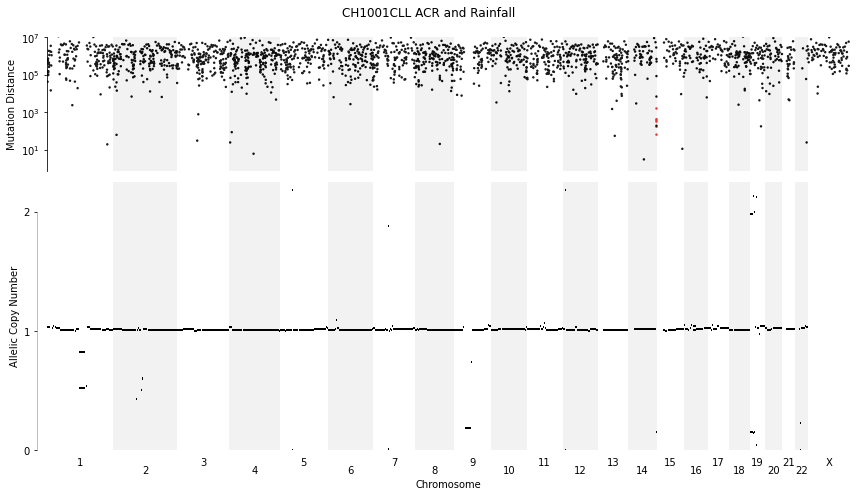

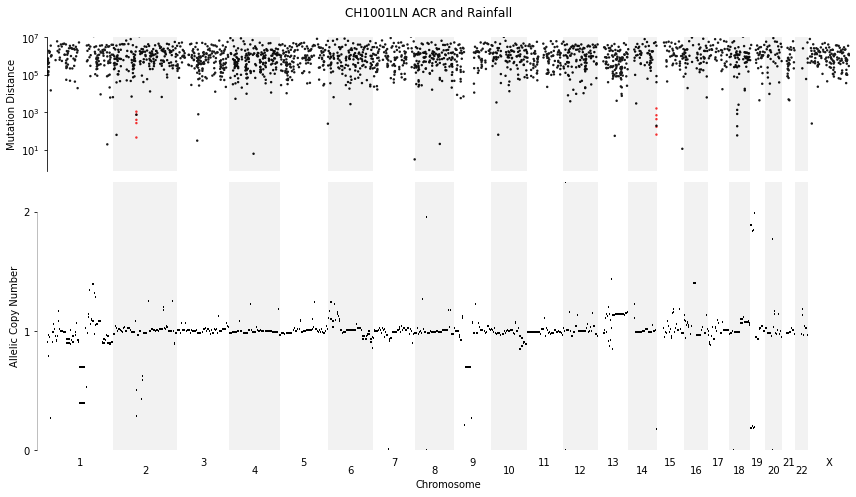

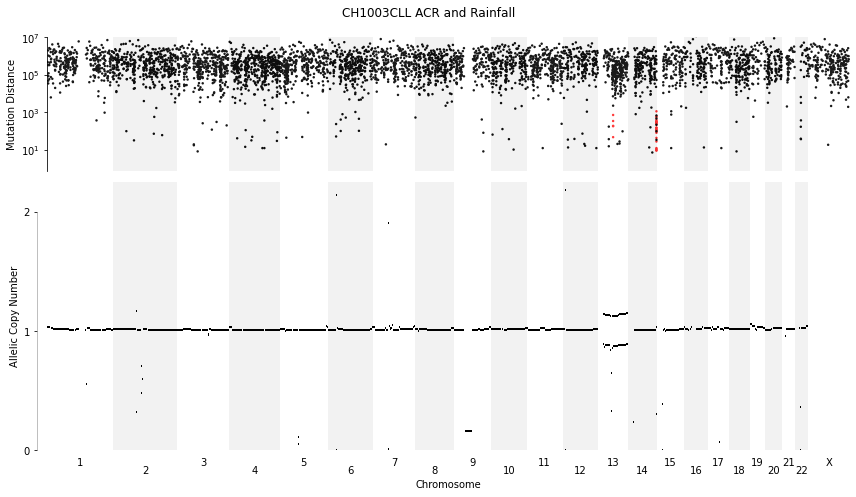

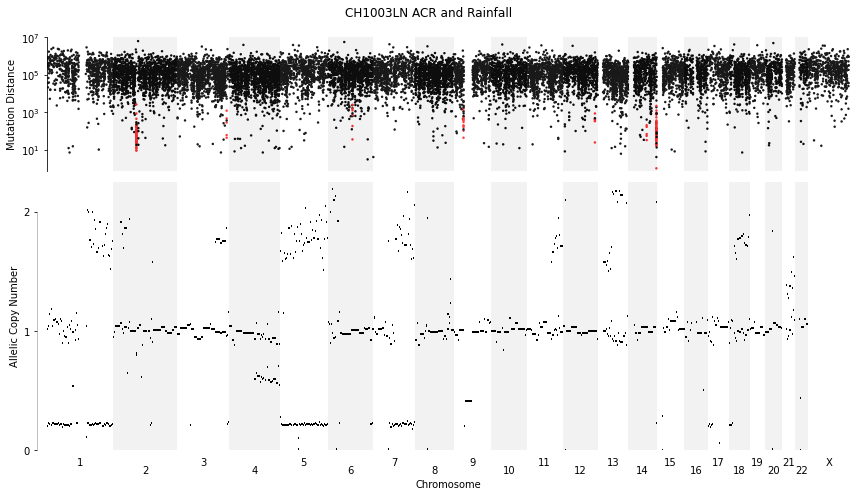

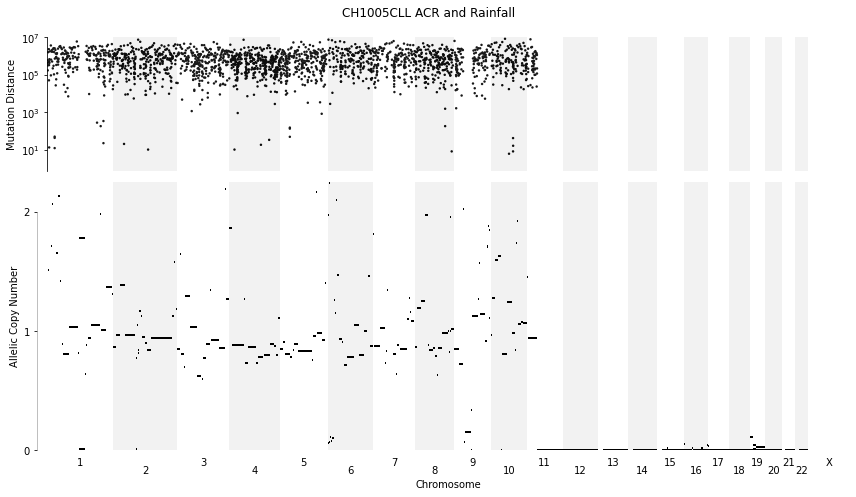

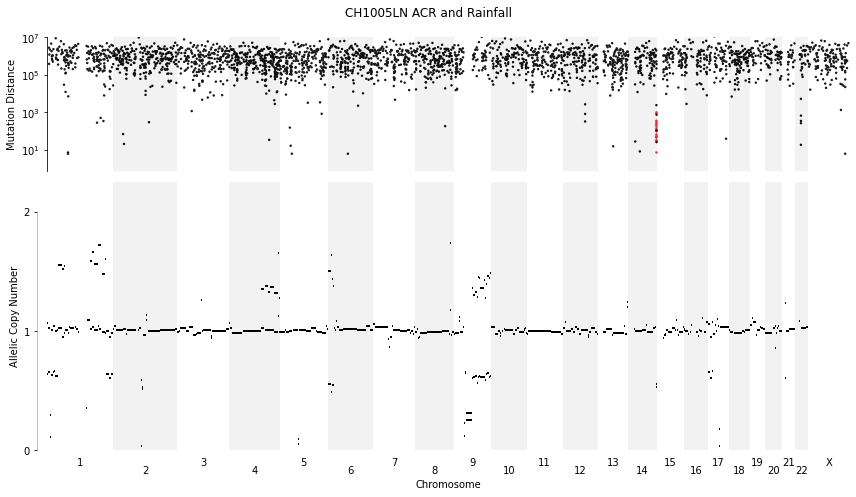

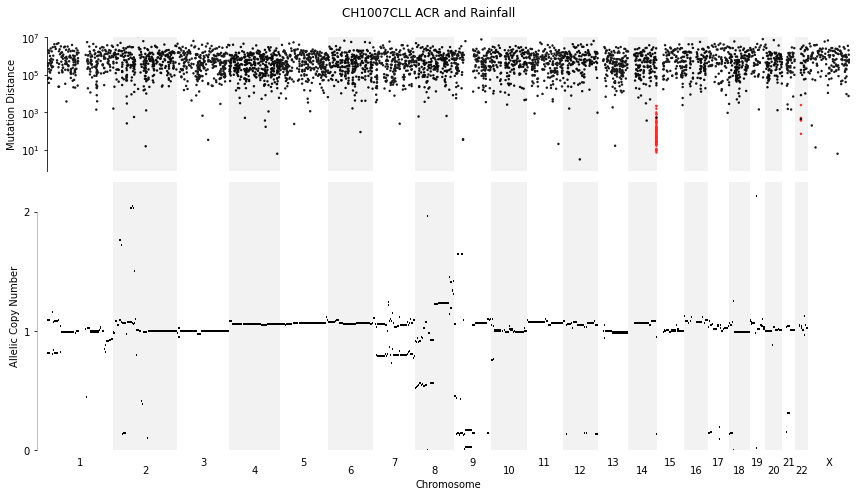

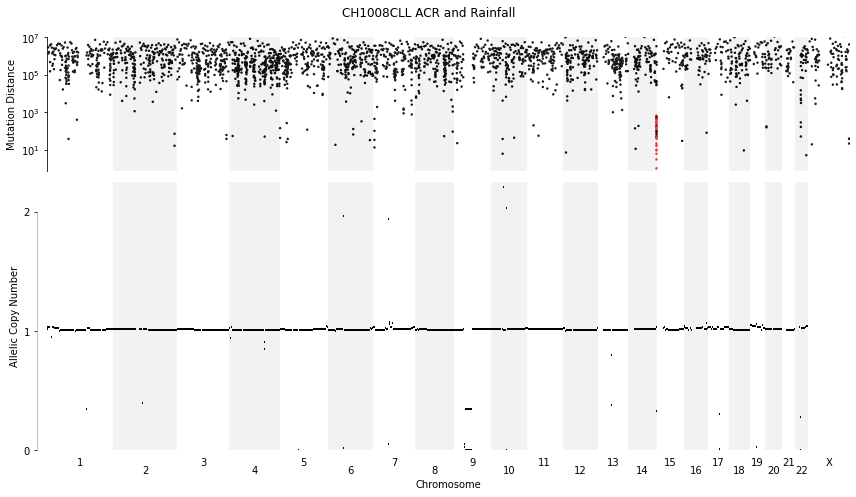

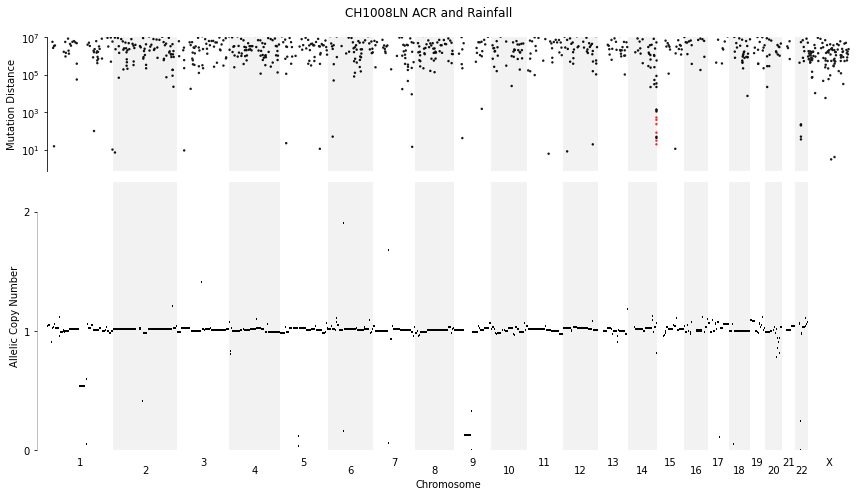

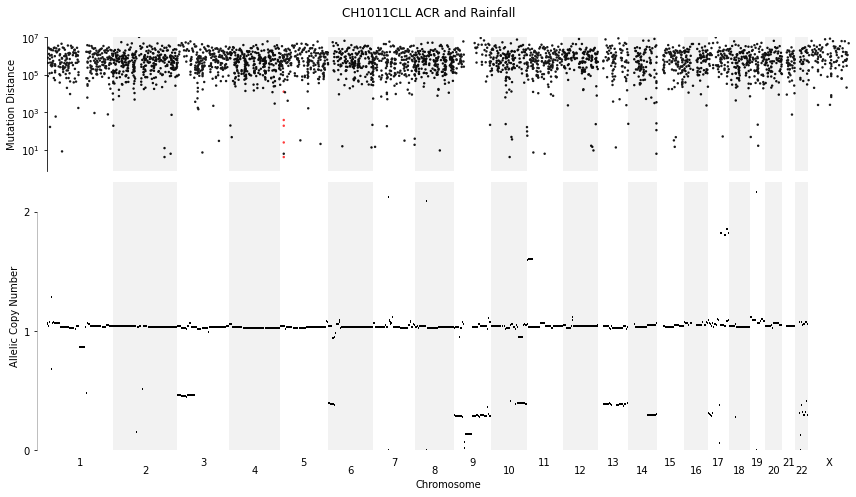

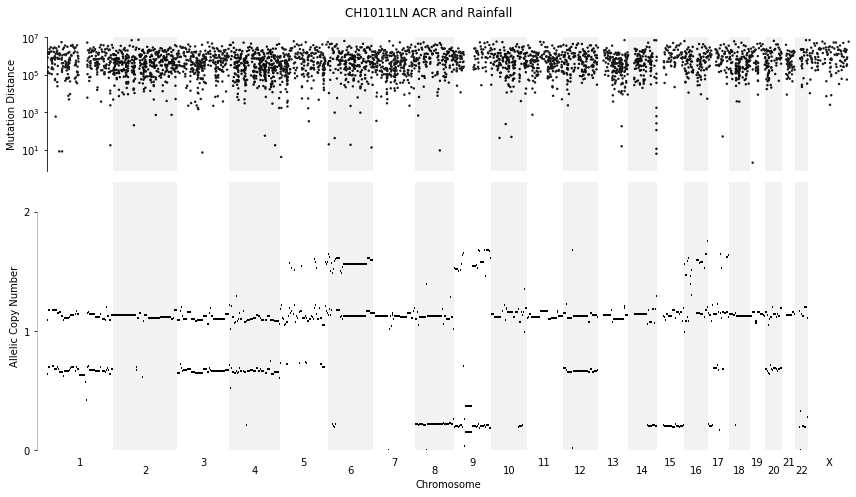

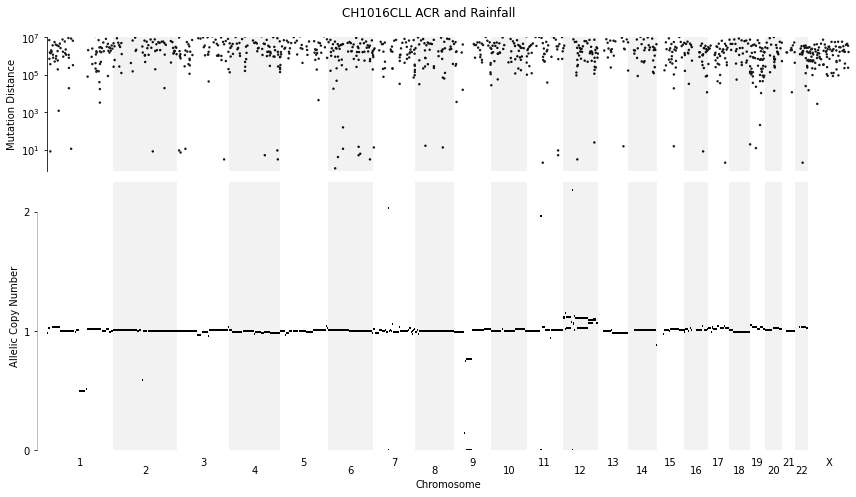

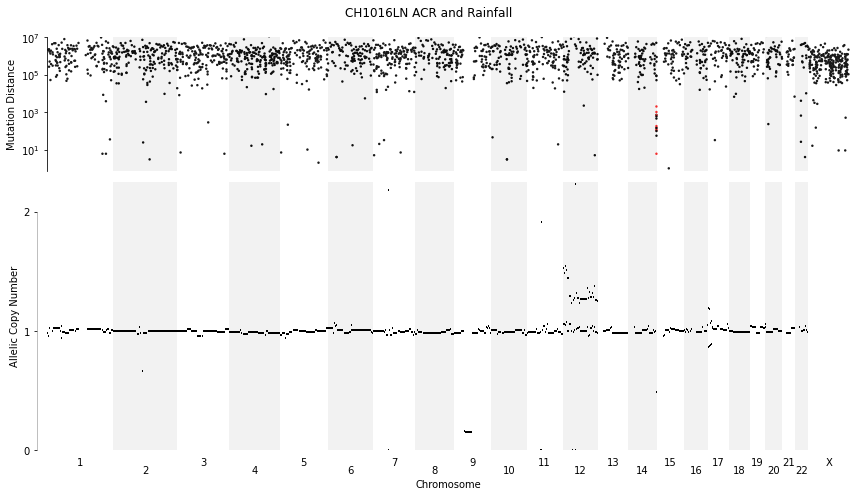

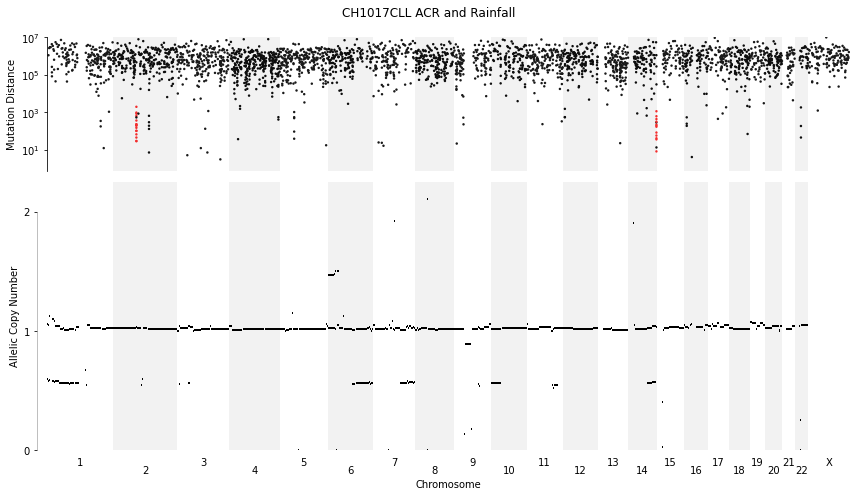

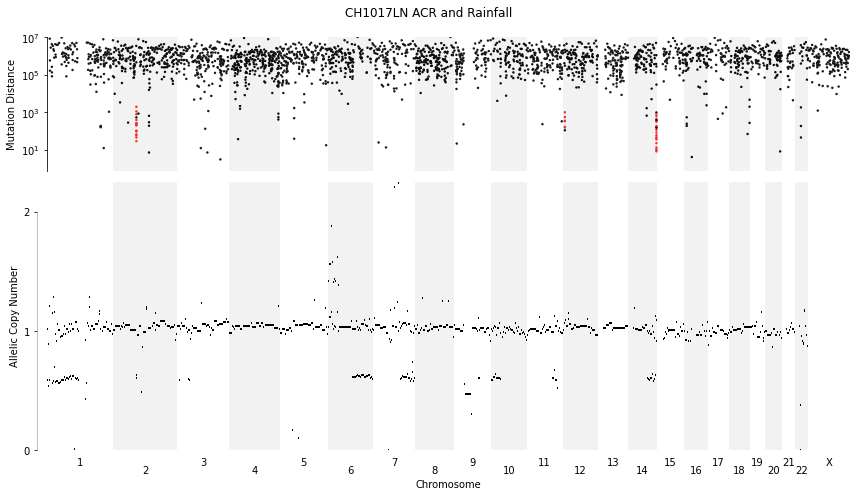

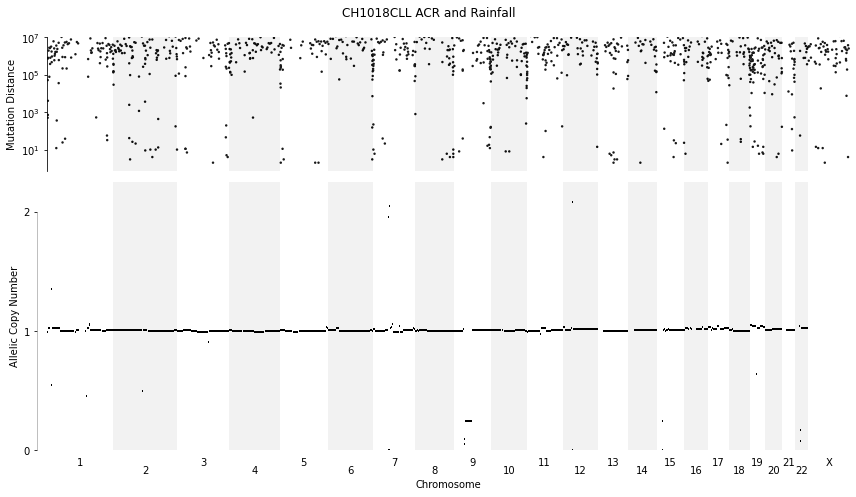

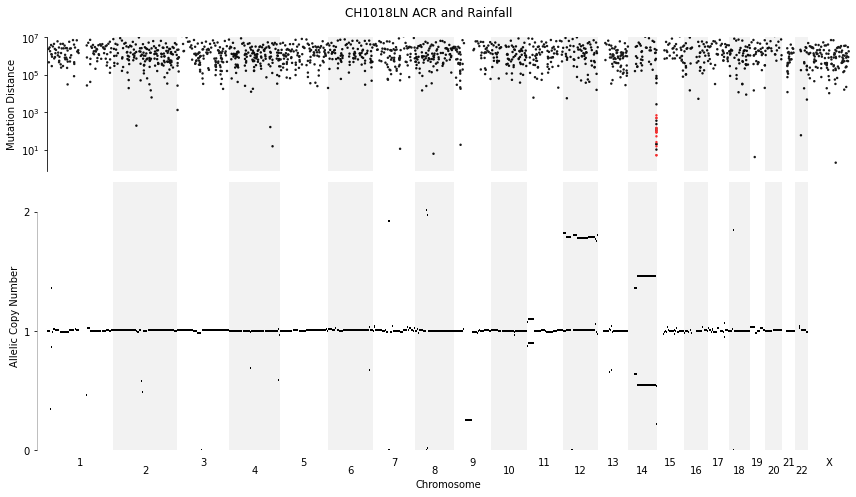

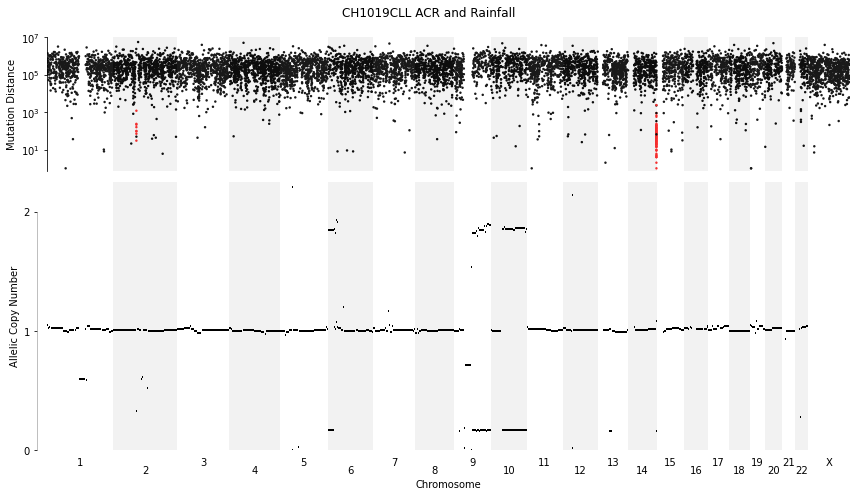

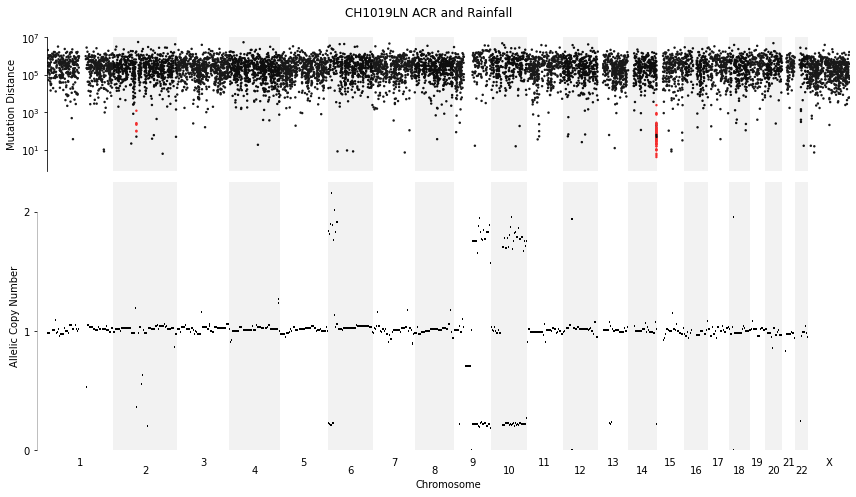

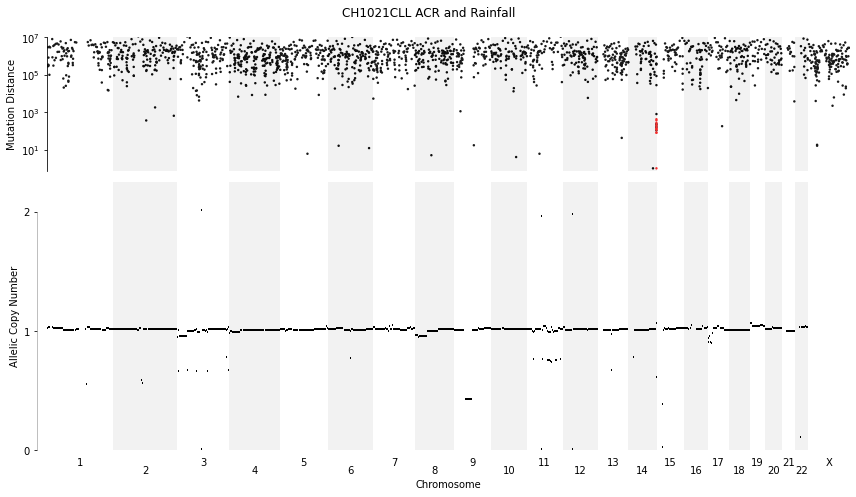

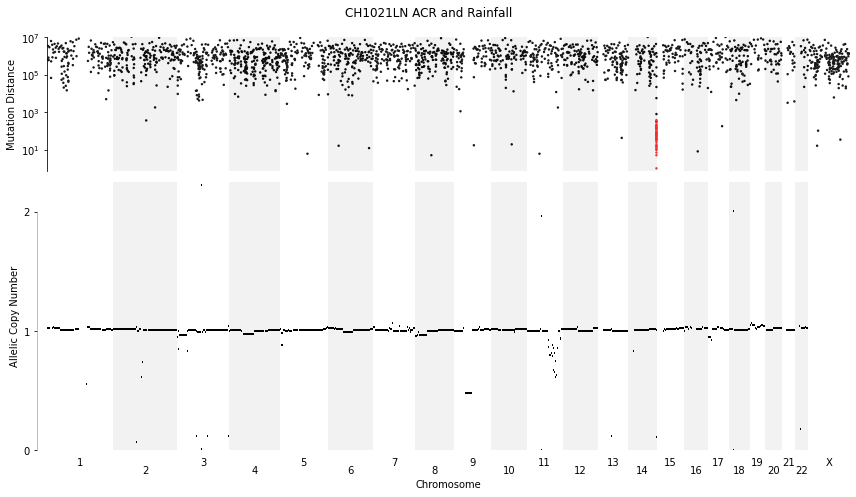

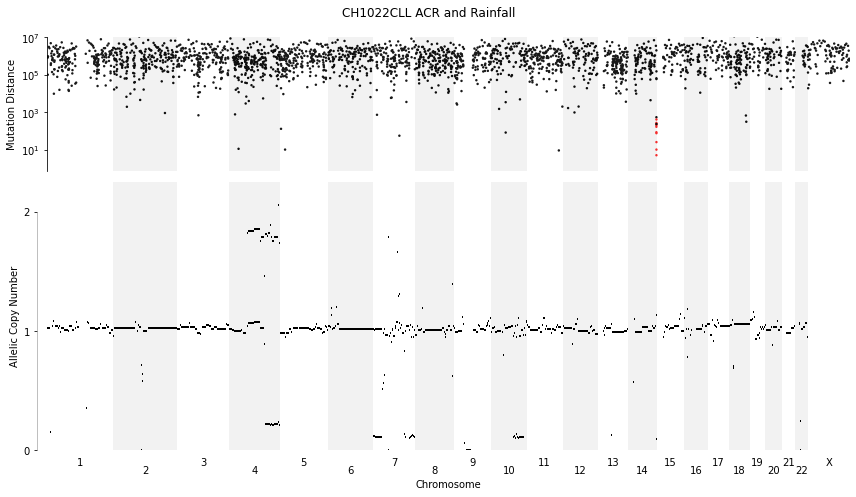

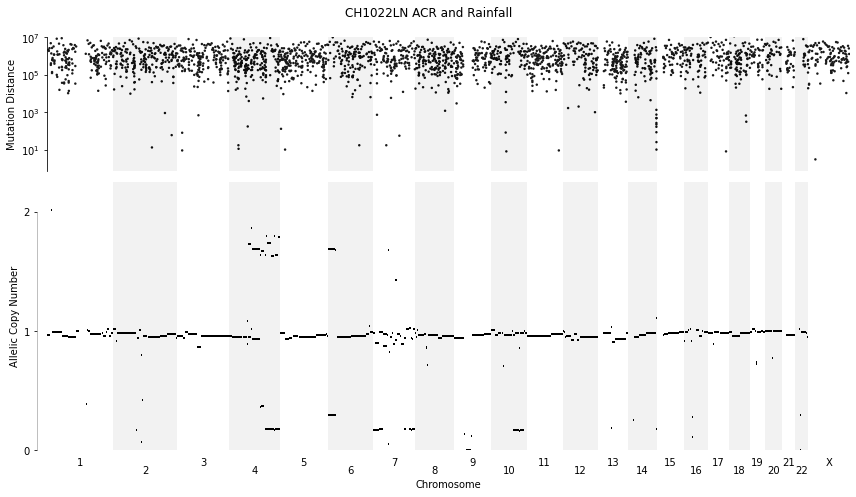

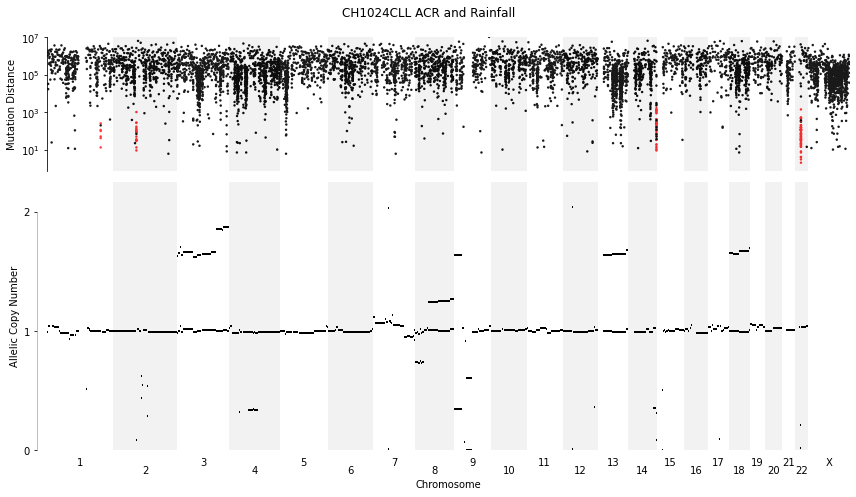

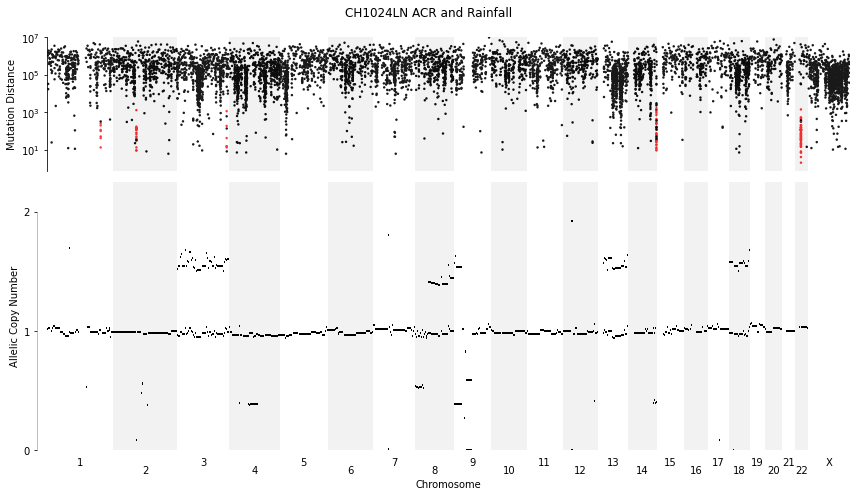

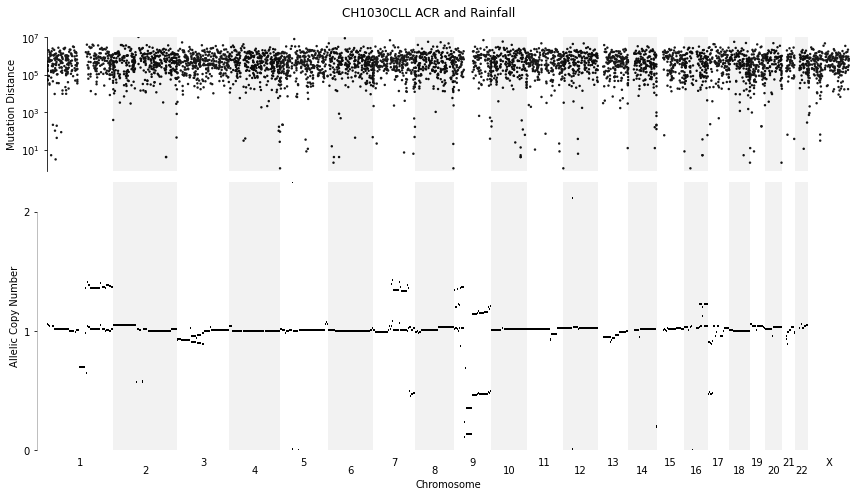

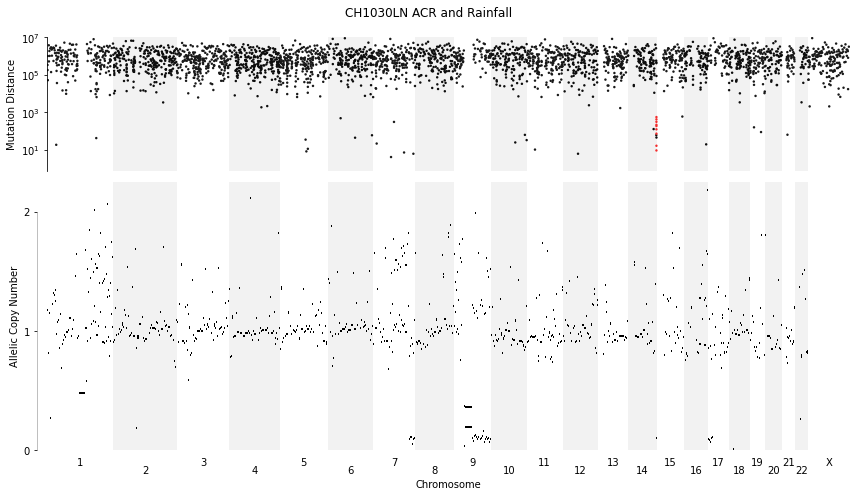

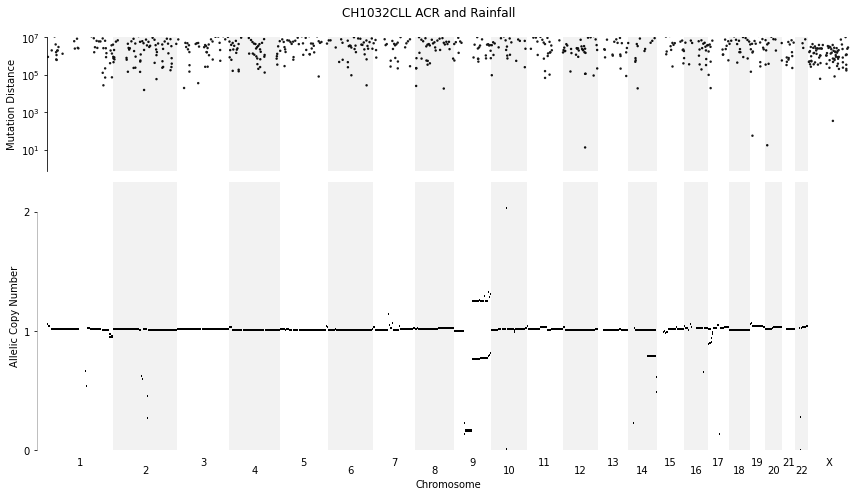

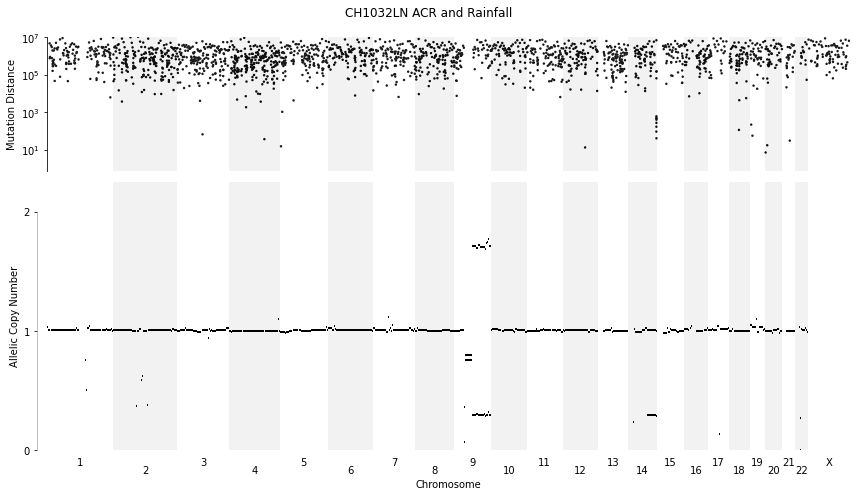

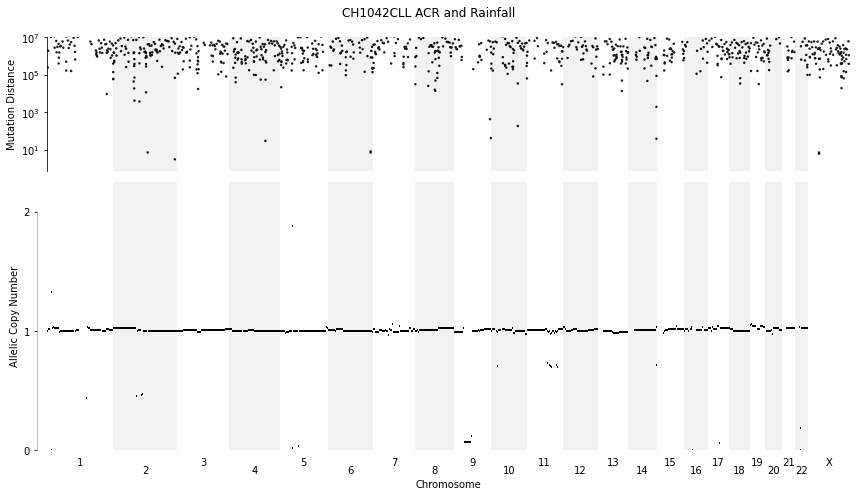

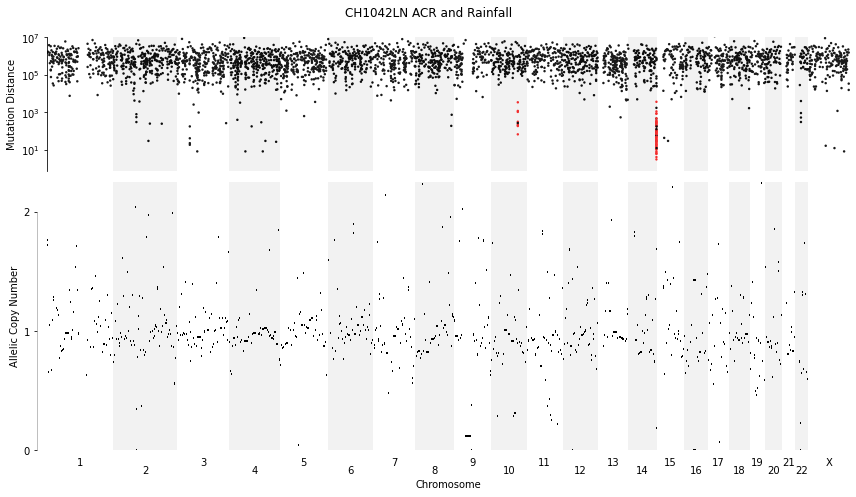

In [27]:
# Plot parameters
description = 'signatures_a1'
marker_colors = 'highlight'  # one of highlight, single, snp_v_indel, by_context
segment_colors = 'black'  # one of black, difference
marker_alpha = 1
fig_width = 12  # generally use 12 for full plot, ~4 for 2-3 chromosomes


# Set FFPE VAF threshold
ffpe_filter_threshold = 0.15


# Combine all the plots in one pdf
with PdfPages('ACR and Rainfall_highlight.pdf') as pdf:
    for i, pair in pairs.iterrows():
        mutation_validation_url = pair['mutation_validator_validated_maf_WGS']
        seg_url = pair['alleliccapseg_tsv_WGS']
        sample_name = pair['case_sample']


        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(fig_width, 7), tight_layout=True, gridspec_kw={'height_ratios':[1,2]})
        maf = pd.read_csv(mutation_validation_url, sep='\t', comment='#', usecols=cols)
        maf['vaf'] = maf.apply(lambda x: x['t_alt_count'] / (x['t_alt_count'] + x['t_ref_count']), axis=1)

        # Filter to consider only mutations with VAF > 0.2
        maf = maf[maf['vaf'] > ffpe_filter_threshold]
        plot_rainfall(maf, sample_name, csize, ax=ax[0], marker_colors=marker_colors, alpha=marker_alpha)
        plot_acr(pd.read_csv(seg_url, sep='\t', comment='#'), sample_name, csize, ax=ax[1], segment_colors=segment_colors)

        fig.suptitle(f'{sample_name} ACR and Rainfall')
        fig.subplots_adjust(top=0.95)

        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['bottom'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['bottom'].set_visible(False)

        ax[0].tick_params(axis='x', bottom=False)
        
        pdf.savefig(fig)



kataegis_cluster_filename = 'all_samples_kataegis_clusters_median.txt'




In [28]:
## Get a summary file of Kataegis regions 

kataegis_cluster_filename = 'all_samples_kataegis_clusters_median_with_number.txt'
ffpe_filter_threshold = 0.15

with open(f'{kataegis_cluster_filename}', 'w') as file:
    file.write('Patient\tSample_name\tCutoff_val\tClusters\tNumber\n')
    for i, pair in pairs.iterrows():
        mutation_validation_url = pair['mutation_validator_validated_maf_WGS']
        seg_url = pair['alleliccapseg_tsv_WGS']
        sample_name = pair['case_sample']
        patient = pair['participant']

        maf = pd.read_csv(mutation_validation_url, sep='\t', comment='#', usecols=cols)
        maf['vaf'] = maf.apply(lambda x: x['t_alt_count'] / (x['t_alt_count'] + x['t_ref_count']), axis=1)
        
        maf = maf[maf['vaf'] > ffpe_filter_threshold]



        clusters, cutoff_val, clust_df = get_kataegis_clusters(maf, csize, sample_name)
        number_cluster = len(clusters)
        file.write(f"{patient}\t{sample_name}\t{cutoff_val}\t{','.join(clusters)}\t{number_cluster}\n")

CH1001CLL cutoff: 28593.37669063138, with 1 clusters


/Users/lil/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CH1001LN cutoff: 25759.220401442326, with 2 clusters
CH1003CLL cutoff: 6787.740343182082, with 2 clusters
CH1003LN cutoff: 3122.465120669051, with 10 clusters
CH1005CLL cutoff: 16871.135129472073, with 0 clusters
CH1005LN cutoff: 17278.187540535513, with 1 clusters
CH1007CLL cutoff: 7711.551369575859, with 6 clusters
CH1008CLL cutoff: 6037.320864185018, with 2 clusters
CH1008LN cutoff: 14289.582978130096, with 1 clusters
CH1011CLL cutoff: 12679.651091267076, with 1 clusters
CH1011LN cutoff: 15368.959511330266, with 0 clusters
CH1016CLL cutoff: 9606.715979985238, with 0 clusters
CH1016LN cutoff: 13615.259555654677, with 1 clusters
CH1017CLL cutoff: 12701.923084677475, with 2 clusters
CH1017LN cutoff: 10497.2174056743, with 3 clusters
CH1018CLL cutoff: 817.0319484522943, with 0 clusters
CH1018LN cutoff: 23781.93120234057, with 1 clusters
CH1019CLL cutoff: 5859.566901023085, with 4 clusters
CH1019LN cutoff: 6700.09482896336, with 4 clusters
CH1021CLL cutoff: 22134.86236097223, with 1 clus

In [29]:
summary_kataegis = pd.read_csv('all_samples_kataegis_clusters_median_with_number.txt', sep ='\t')

summary_kataegis['Sample_type'] = summary_kataegis.Sample_name.str[-2:]

idx = summary_kataegis.Sample_type == 'LL'
summary_kataegis.loc[idx, 'Sample_type'] ='CLL'
summary_kataegis= summary_kataegis[summary_kataegis.Patient!='CH1007']
summary_kataegis.pivot(columns = 'Sample_type', index = 'Patient', values ='Number')


Sample_type,CLL,LN
Patient,,
CH1001,1,2
CH1003,2,10
CH1005,0,1
CH1008,2,1
CH1011,1,0
CH1016,0,1
CH1017,2,3
CH1018,0,1
CH1019,4,4


# Test on one sample

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plot_cnv_profile import add_background, plot_acr_static, prepare_df

CH1011LN cutoff: 17960.517417957923, with 0 clusters
CH1011LN cutoff: 17960.517417957923, with 0 clusters


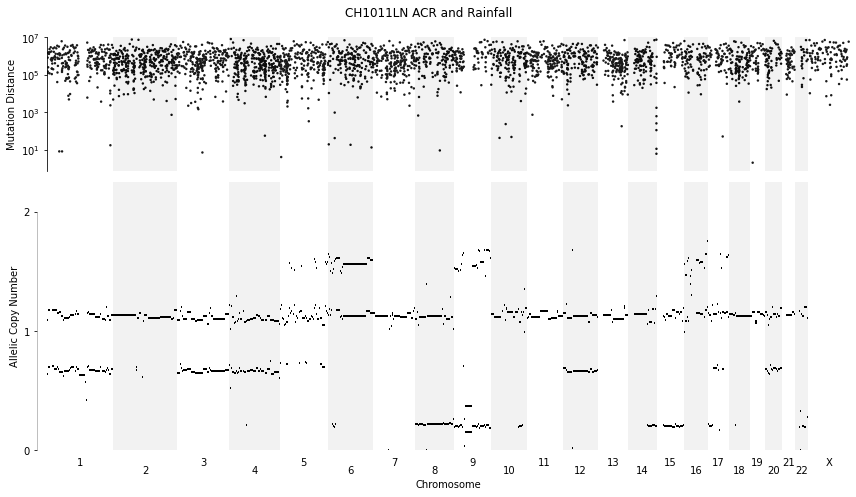

In [23]:
csize = {'1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276, '5': 180915260, '6': 171115067, '7': 159138663,
         '8': 146364022,
         '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895, '13': 115169878, '14': 107349540,
         '15': 102531392,
         '16': 90354753, '17': 81195210, '18': 78077248, '19': 59128983, '20': 63025520, '21': 48129895, '22': 51304566,
         'X': 156040895}  #, 'Y': 57227415}


# Can define a subset of chromosomes to only plot certain chromosomes
# csize = {'2': 243199373, '3': 198022430}


description = 'signatures_a1'
marker_colors = 'highlight'  # one of highlight, single, snp_v_indel, by_context
segment_colors = 'black'  # one of black, difference
marker_alpha = 1
fig_width = 12  # generally use 12 for full plot, ~4 for 2-3 chromosomes
ffpe_filter_threshold = 0.2



maf_fn = 'example_validated.maf'
seg_fn = 'example_segfile.tsv'
sample_name ='CH1011LN'

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(fig_width, 7), tight_layout=True, gridspec_kw={'height_ratios':[1,2]})
maf = pd.read_csv(maf_fn, sep='\t', comment='#', usecols=cols)
maf['vaf'] = maf.apply(lambda x: x['t_alt_count'] / (x['t_alt_count'] + x['t_ref_count']), axis=1)

# Filter to consider only mutations with VAF > 0.2
maf = maf[maf['vaf'] > ffpe_filter_threshold]

clusters, cutoff_val, clust_df = get_kataegis_clusters(maf, csize, sample_name)

plot_rainfall(maf, sample_name, csize, ax=ax[0], marker_colors='highlight', alpha=marker_alpha)
plot_acr(pd.read_csv(seg_fn, sep='\t', comment='#'), sample_name, csize, ax=ax[1], segment_colors=segment_colors)

fig.suptitle(f'{sample_name} ACR and Rainfall')
fig.subplots_adjust(top=0.95)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[0].tick_params(axis='x', bottom=False)